loss is defined as the follows: loss= sum(pairwise_distance) / sum(distance_of_medoids)

In [1]:
from medoid_lib import api
import matplotlib.pyplot as plt
import importlib
# importlib.reload(api)

In [11]:
import importlib
importlib.reload(api)

<module 'medoid_lib.api' from '/home/t/tianyang/curantis/medoid/medoid_lib/api.py'>

In [3]:
from medoid_lib.dtw_lib._dtw_lib import fastdtw
f = lambda x, y: fastdtw(x, y, 1)[0]

In [19]:
# def calculate_loss(medoids, matrix):
def get_pairwise(cluster, matrix):
    length = len(cluster)
    sum = 0
    count = 0
    for i in range(length):
        for j in range(i, length):
            sum += matrix[i][j]
            count += 1
    return sum / length #this only divide the number of the segs in the cluster

def get_pairwise_medoids(medoids, f):
    length = len(medoids)
    sum = 0
    count = 0
    for i in range(0, length):
        for j in range(i, length):
            sum += f(medoids[i], medoids[j])
            count += 1
    return sum

def get_loss_for_num(segs, matrix, k, f, mode='average'):
    represents = api.get_medoids(matrix, segs, k, 0)
    medoids = list(map(lambda r: r[0], represents))
    clusters = api.convert_label_to_clusters(api.get_hieratical_cluster(matrix, k, mode))
    numerator= 0
    for c in clusters:
        numerator += get_pairwise(c, matrix)
    denominator = get_pairwise_medoids(medoids, f)
    return numerator / k

In [34]:
def get_activities_enough(user):
    activities = api.load(['medoid/data/all_activities'])[0][user]
    f = lambda x: len(api.load(
            ['medoid/data/user' + str(user) +  '_' + x + '_segments_5'])[0]) > 50
    return list(filter(f, activities))                                           

In [22]:
def get_matrix_seg(user, activity):
    prefix = 'medoid/data/user' + str(user) + '_' + activity
    return api.load([prefix + '_matrix_5', prefix + '_segments_5'])

In [23]:
def plot_num(matrix, segs, f, title="", mode='average', name="", save=False):
    x = list(range(1, 10))
    y = []
    for i in x:
        y.append(get_loss_for_num(segs, matrix, i, f, mode))
    plt.title(title)
    plt.plot(x, y)
    if save: plt.savefig(name)

In [24]:
def point_to_line_dist(start, end, point):
    import math
    a = 1.0 * (start[1] - end[1]) / (start[0] - end[0])
    c = end[1] - a * end[0]
    return abs(a * point[0] - point[1] + c) / math.sqrt(a **2 + 1)
import numpy as np

In [25]:
def get_elbow(points):
    start = points[0]
    end = points[-1]
    dist = list(map(lambda p: point_to_line_dist(start, end, p), points))
    return np.argmax(dist) + 1

In [26]:
def get_cluster_num(matrix, segs, f, mode='average'):
    x = list(range(1, 10))
    y = []
    for i in x:
        y.append(get_loss_for_num(segs, matrix, i, f, mode))
    points = list(map(lambda i: (i, y[i - 1]), x))
    return get_elbow(points)

In [27]:
def get_points(matrix, segs, f, mode='average'):
    x = list(range(1, 10))
    y = []
    for i in x:
        y.append(get_loss_for_num(segs, matrix, i, f, mode))
    points = list(map(lambda i: (i, y[i - 1]), x))
    return points

In [168]:
# def calculate_cluster_sum(matrix, index, cluster):
#     return list(map(lambda i: matrix[i][index], cluster))
import math
def one_cluster_silhouette_score(matrix, segs, cluster, clusters):
    length = len(cluster)
    if length == 1: return [0]
    f_sum = lambda idx, cluster: sum(map(lambda i: matrix[i][idx], cluster))
    score = []
    for i in cluster:
        a = f_sum(i, cluster) / (length - 1)
        b = min(map(lambda c: f_sum(i, c) / len(c), [c for c in clusters if c != cluster]))
        score.append((b - a) / max(a, b))
    return score
def calculate_silhouette_score_with_num(matrix, segs, k, linkage='average'):
    clusters = api.convert_label_to_clusters(api.get_hieratical_cluster(matrix, k, linkage))
    score = []
    for c in clusters:
        score.extend(one_cluster_silhouette_score(matrix, segs, c, clusters))
    return np.mean(score)

In [133]:
score = calculate_silhouette_score_with_num(data[0], data[1], 3)

In [178]:
def get_silhouette_score(matrix, segs):
    y = []
    for i in range(2, 10):
        y.append(calculate_silhouette_score_with_num(matrix, segs, i))
    return y
def get_num_cluster_silhouette(matrix, segs):
    return np.argmax(get_silhouette_score(matrix, segs)) + 2 # as num starts from 2

In [180]:
def plot_silhouette_score(matrix, segs, title, name="", save=False):
    x = list(range(2, 10))
    y = get_silhouette_score(matrix, segs)
    plt.title(title)
    plt.plot(x, y)
    if save: plt.savefig(name)

In [112]:
user1_activities = get_activities(1)
data = get_matrix_seg(1, user1_activities[0])

In [114]:
user1_activities[0]
len(data[0])

409

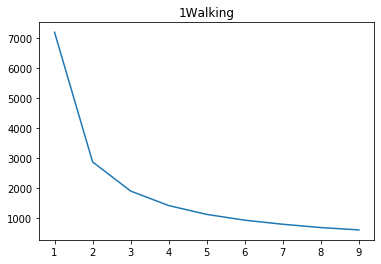

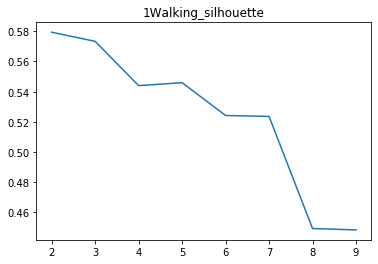

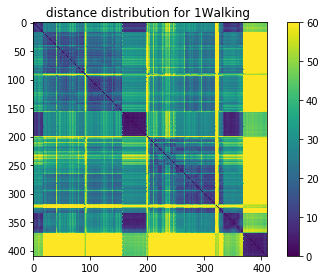

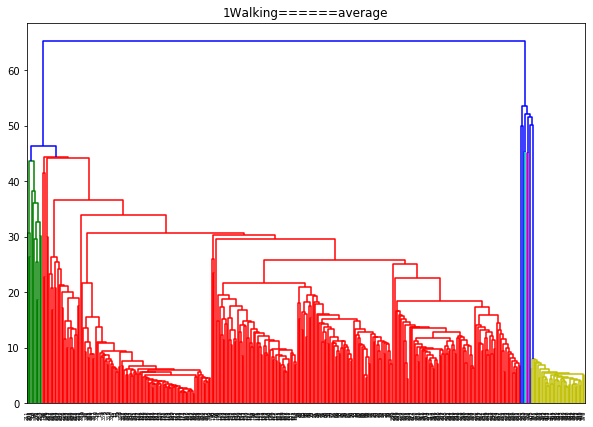

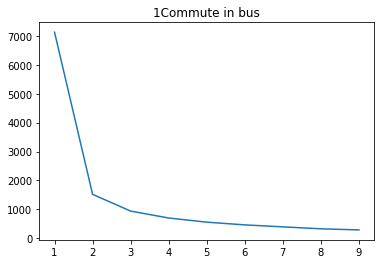

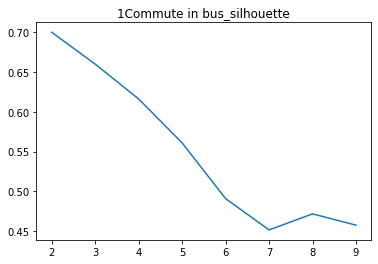

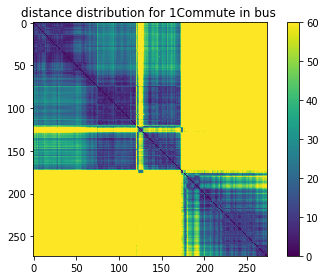

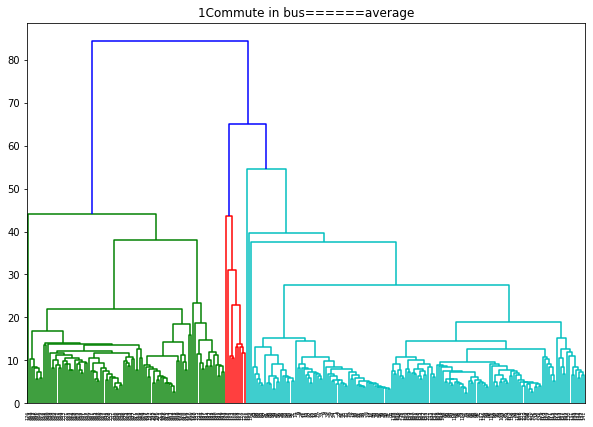

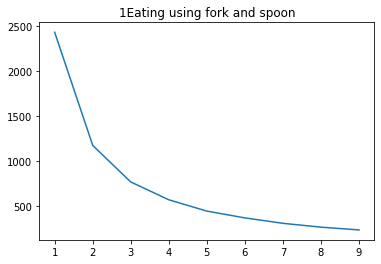

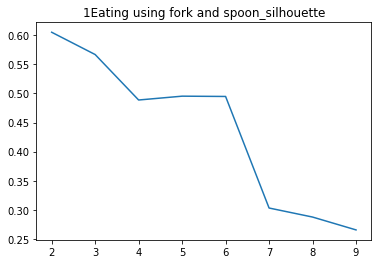

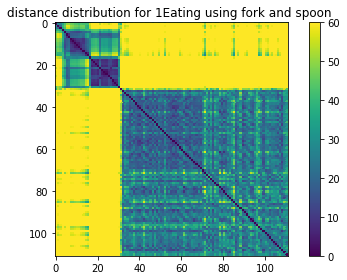

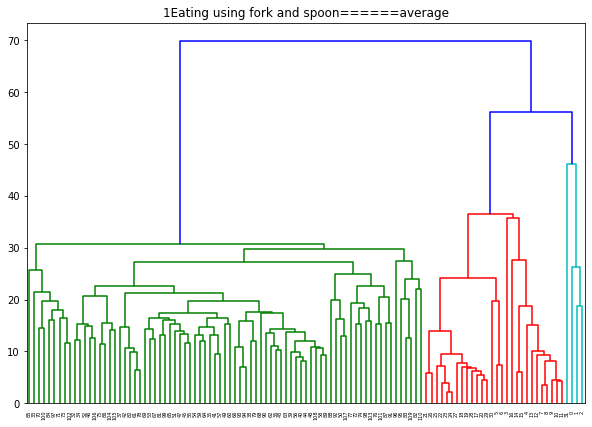

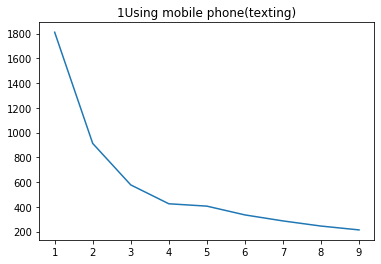

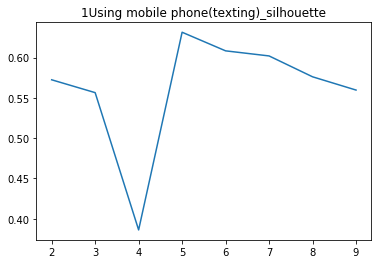

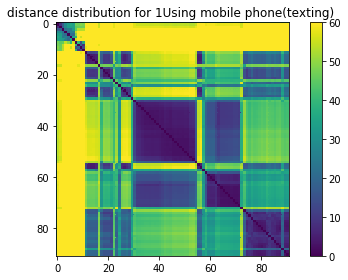

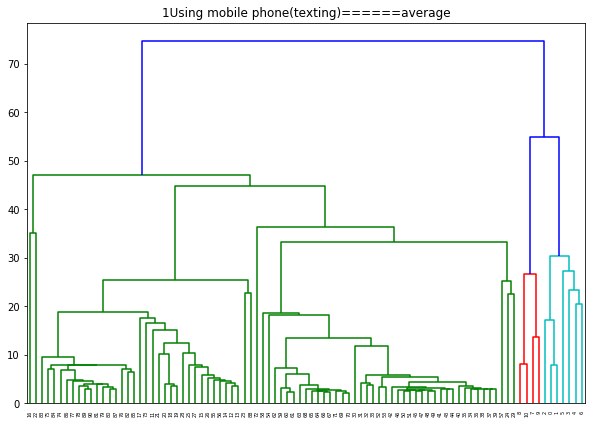

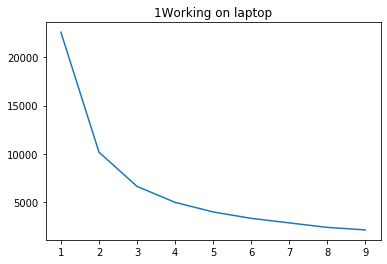

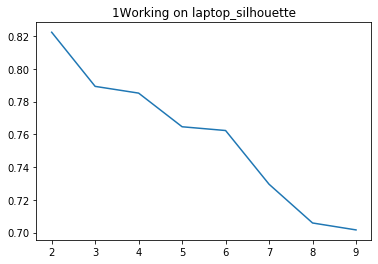

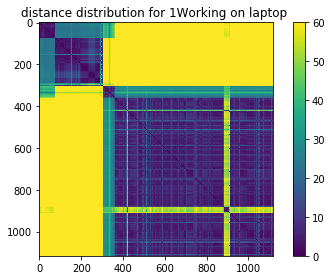

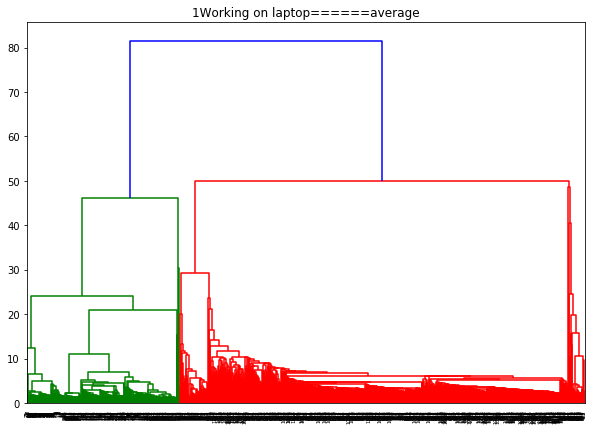

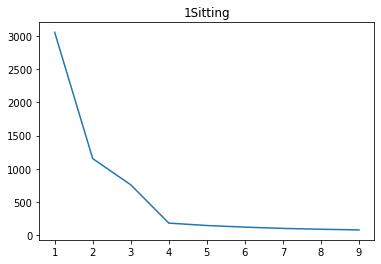

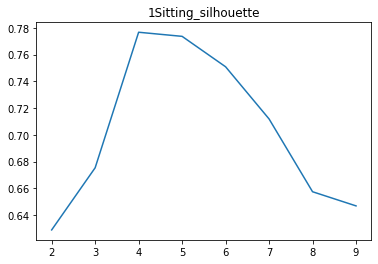

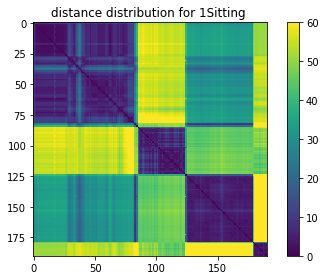

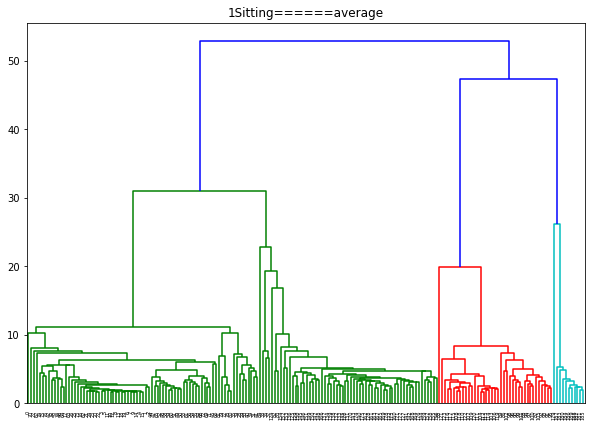

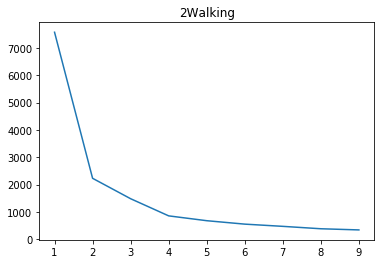

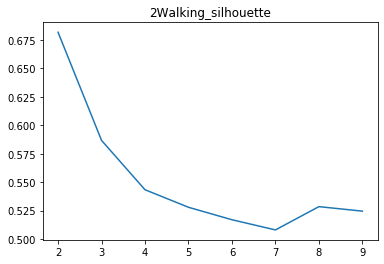

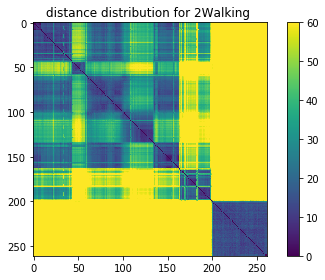

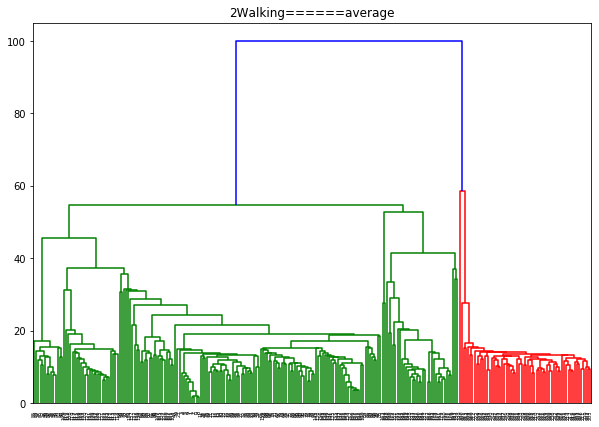

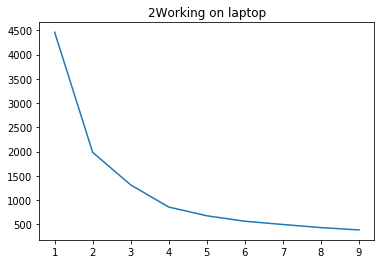

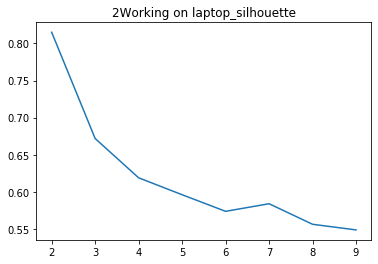

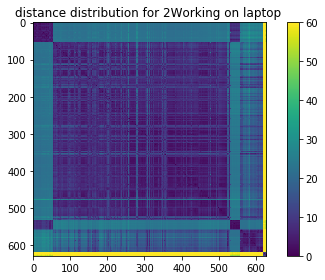

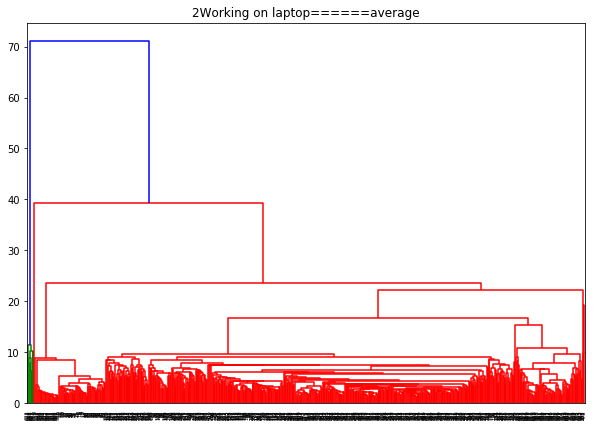

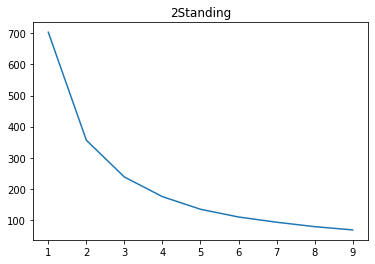

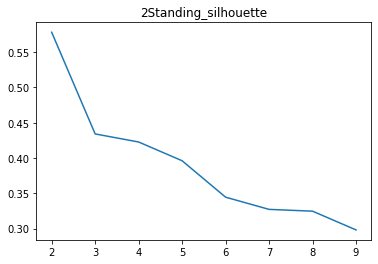

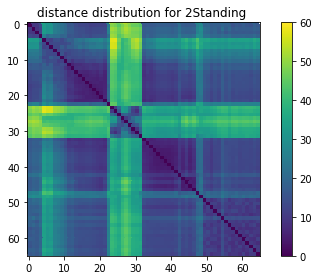

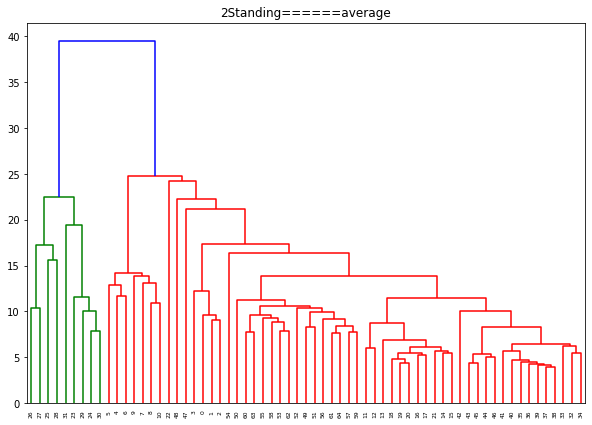

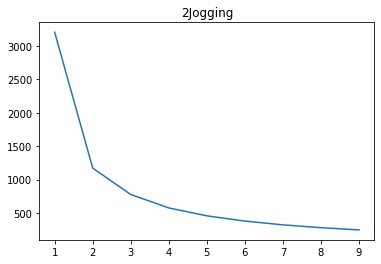

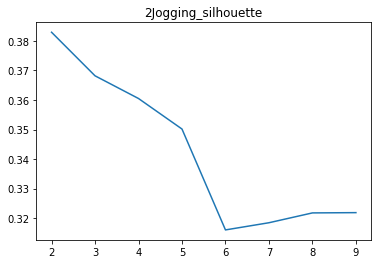

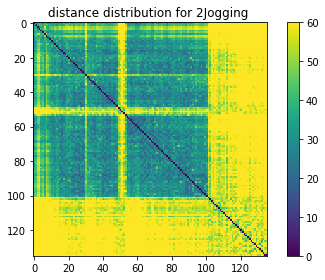

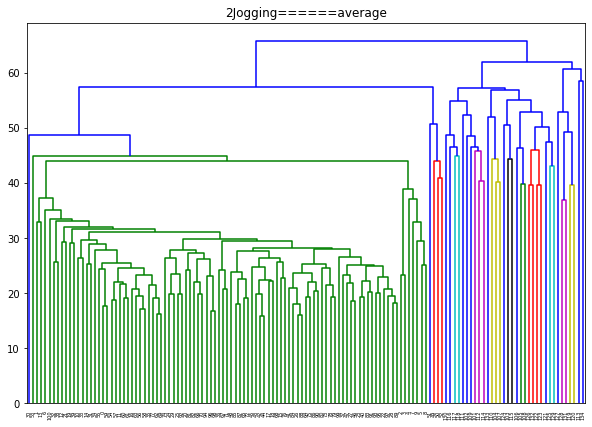

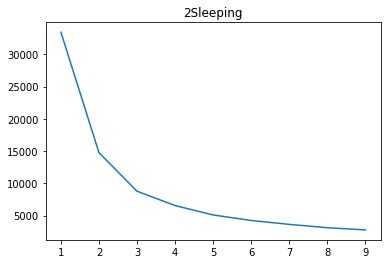

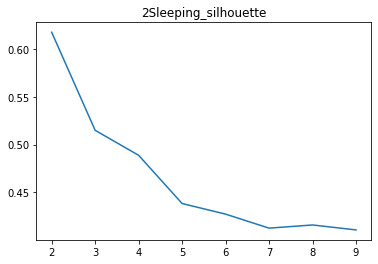

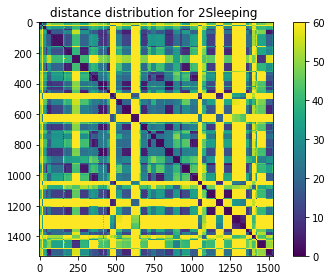

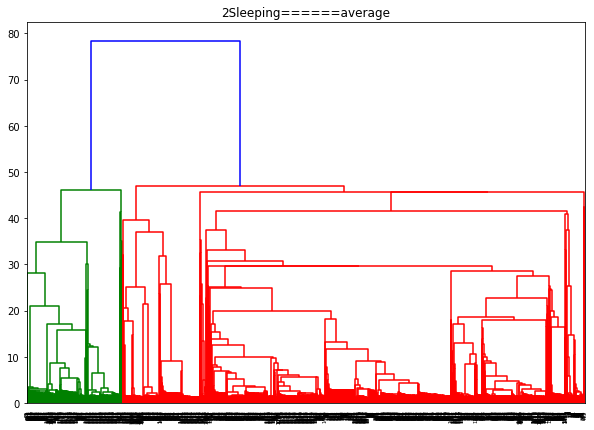

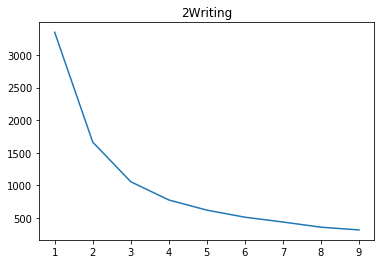

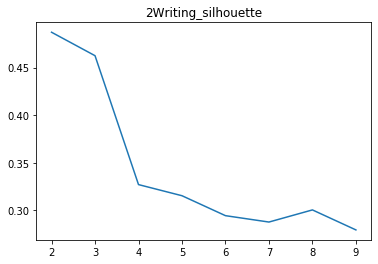

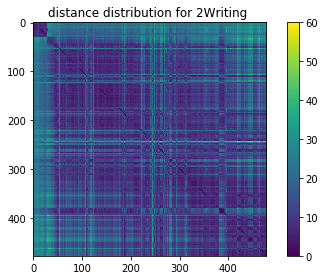

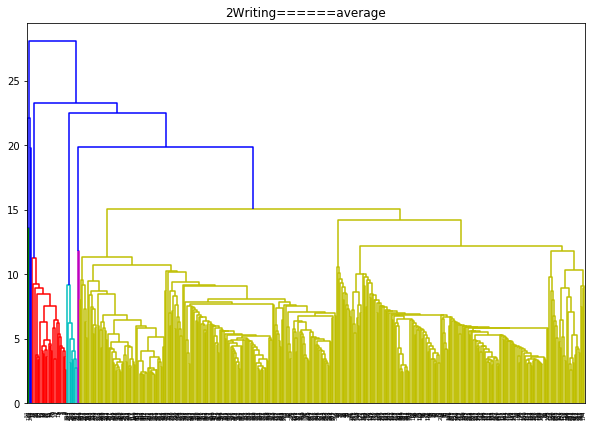

In [186]:
for user in [1,2]:
    for activity in get_activities_enough(user):
        data = get_matrix_seg(user, activity)
        title = str(user) + activity
        store_name = 'records/' + title
        num = get_cluster_num(data[0], data[1], f)
        plot_num(data[0], data[1], f, title=title, name=store_name + '_num=' + str(num), save=True)
        plt.show()
        num_silhouette = get_num_cluster_silhouette(data[0], data[1])
        plot_silhouette_score(data[0], data[1], title + '_silhouette'
                              , name = store_name + '_num_silhouette='+ str(num_silhouette), save=True)
        api.plot_matrix(data[0], title, name=store_name + '_matrix', save=True)
        api.hieratical_plot(data[0], data[1], 'average', title, name=store_name + '_clustering', save=True)